In [1]:
from src.trainer import VAETrainer
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

from torch.utils.data import DataLoader, random_split

from corruption_utils import corruptions

%load_ext autoreload
%autoreload 2

In [2]:
from src.utils.trainer_utils import (
    get_hierarchical_vae_trainer, 
    get_clearvae_trainer,
    get_clearmimvae_trainer, 
    get_cleartcvae_trainer
)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
%%capture
mnist = torchvision.datasets.MNIST("../data", train=True, download=True)

In [5]:
np.random.seed(101)
torch.manual_seed(101)

In [6]:
from src.utils.data_utils import StyledMNISTGenerator, StyledMNIST

generator = StyledMNISTGenerator(
    mnist,
    {
        lambda x: corruptions.rgb_change(x, "red"): 0.15,
        lambda x: corruptions.rgb_change(x, "green"): 0.25,
        lambda x: corruptions.rgb_change(x, "blue"): 0.15,
        lambda x: corruptions.rgb_change(x, "yellow"): 0.15,
        lambda x: corruptions.rgb_change(x, "cyan"): 0.2,
        lambda x: corruptions.rgb_change(x, "magenta"): 0.1,
    },
)



dataset = StyledMNIST(
    generator, transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0])
)

train, test, valid = random_split(dataset, [40000, 10000, 10000])


Generating dataset: 100%|██████████| 60000/60000 [00:02<00:00, 22643.44item/s]


In [7]:
train_loader = DataLoader(train, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid, batch_size=128, shuffle=False)
test_loader = DataLoader(test, batch_size=128, shuffle=False)


In [ ]:
trainer_kwargs = {
    "beta": 1 / 8,
    "vae_lr": 5e-4,
    "z_dim": 16,
    "alpha": 1e2,
    "temperature": 0.3,
    "device": device,
    "in_channel": 3,
}

models = {
    "gvae": (
        get_hierarchical_vae_trainer,
        {
            "beta": trainer_kwargs["beta"],
            "vae_lr": trainer_kwargs["vae_lr"],
            "z_dim": trainer_kwargs["z_dim"],
            "group_mode": "GVAE",
            "device": trainer_kwargs["device"],
            "in_channel": trainer_kwargs["in_channel"],
        },
    ),
    "mlvae": (
        get_hierarchical_vae_trainer,
        {
            "beta": trainer_kwargs["beta"],
            "vae_lr": trainer_kwargs["vae_lr"],
            "z_dim": trainer_kwargs["z_dim"],
            "group_mode": "MLVAE",
            "device": trainer_kwargs["device"],
            "in_channel": trainer_kwargs["in_channel"],
        },
    ),
    "clear": (
        get_clearvae_trainer,
        {"ps": True, **trainer_kwargs},
    ),
    "clear-tc": (
        get_cleartcvae_trainer,
        {"la": 1, "factor_cls_lr": 1e-4, **trainer_kwargs},
    ),
    "clear-mim (L1OutUB)": (
        get_clearmimvae_trainer,
        {
            "mi_estimator": "L1OutUB",
            "la": 3,
            "mi_estimator_lr": 2e-3,
            **trainer_kwargs,
        },
    ),
    "clear-mim (CLUB-S)": (
        get_clearmimvae_trainer,
        {
            "mi_estimator": "CLUBSample",
            "la": 3,
            "mi_estimator_lr": 2e-3,
            **trainer_kwargs,
        },
    ),
}

In [9]:
trained_model = dict()
for vae_name, (trainer_func, params) in models.items():
    print(f"\nTraining {vae_name}:")
    trainer: VAETrainer = trainer_func(**params)
    trainer.fit(31, train_loader, valid_loader)
    trained_model[vae_name] = trainer


Training gvae:


val-epoch 0: 100%|██████████| 79/79 [00:00<00:00, 294.09it/s]


val_recontr_loss=366.532, val_kl_c=22.420, val_kl_s=19.317
gMIG: 0.128; mse: 366.532


val-epoch 5: 100%|██████████| 79/79 [00:00<00:00, 307.29it/s]


val_recontr_loss=142.135, val_kl_c=26.200, val_kl_s=22.150
gMIG: 0.202; mse: 142.135


val-epoch 10: 100%|██████████| 79/79 [00:00<00:00, 321.67it/s]


val_recontr_loss=69.935, val_kl_c=26.164, val_kl_s=22.929
gMIG: 0.224; mse: 69.935


val-epoch 15: 100%|██████████| 79/79 [00:00<00:00, 326.78it/s]


val_recontr_loss=43.161, val_kl_c=25.720, val_kl_s=23.170
gMIG: 0.233; mse: 43.161


val-epoch 20: 100%|██████████| 79/79 [00:00<00:00, 308.48it/s]


val_recontr_loss=29.952, val_kl_c=25.724, val_kl_s=23.264
gMIG: 0.239; mse: 29.952


val-epoch 25: 100%|██████████| 79/79 [00:00<00:00, 295.13it/s]


val_recontr_loss=24.530, val_kl_c=25.757, val_kl_s=22.915
gMIG: 0.247; mse: 24.53


val-epoch 30: 100%|██████████| 79/79 [00:00<00:00, 322.68it/s]


val_recontr_loss=21.092, val_kl_c=25.094, val_kl_s=23.014
gMIG: 0.246; mse: 21.092

Training mlvae:


val-epoch 0: 100%|██████████| 79/79 [00:00<00:00, 314.92it/s]


val_recontr_loss=367.194, val_kl_c=12.852, val_kl_s=19.171
gMIG: 0.136; mse: 367.194


val-epoch 5: 100%|██████████| 79/79 [00:00<00:00, 316.88it/s]


val_recontr_loss=142.102, val_kl_c=14.351, val_kl_s=22.262
gMIG: 0.161; mse: 142.102


val-epoch 10: 100%|██████████| 79/79 [00:00<00:00, 236.51it/s]


val_recontr_loss=69.459, val_kl_c=14.386, val_kl_s=23.042
gMIG: 0.18; mse: 69.459


val-epoch 15: 100%|██████████| 79/79 [00:00<00:00, 303.31it/s]


val_recontr_loss=43.671, val_kl_c=13.952, val_kl_s=22.786
gMIG: 0.197; mse: 43.671


val-epoch 20: 100%|██████████| 79/79 [00:00<00:00, 310.82it/s]


val_recontr_loss=30.488, val_kl_c=13.603, val_kl_s=22.871
gMIG: 0.196; mse: 30.488


val-epoch 25: 100%|██████████| 79/79 [00:00<00:00, 286.89it/s]


val_recontr_loss=24.320, val_kl_c=13.924, val_kl_s=22.656
gMIG: 0.206; mse: 24.32


val-epoch 30: 100%|██████████| 79/79 [00:00<00:00, 305.82it/s]


val_recontr_loss=21.400, val_kl_c=13.943, val_kl_s=22.470
gMIG: 0.209; mse: 21.4

Training clear:


val-epoch 0: 100%|██████████| 79/79 [00:00<00:00, 89.18it/s] 


val_recontr_loss=388.814, val_kl_c=13.845, val_kl_s=19.686, val_c_loss=0.495, val_s_loss=0.110
gMIG: 0.294; mse: 388.814


val-epoch 5: 100%|██████████| 79/79 [00:00<00:00, 212.46it/s]


val_recontr_loss=138.547, val_kl_c=17.122, val_kl_s=22.698, val_c_loss=0.349, val_s_loss=0.110
gMIG: 0.395; mse: 138.547


val-epoch 10: 100%|██████████| 79/79 [00:00<00:00, 218.16it/s]


val_recontr_loss=70.371, val_kl_c=18.167, val_kl_s=23.070, val_c_loss=0.333, val_s_loss=0.109
gMIG: 0.419; mse: 70.371


val-epoch 15: 100%|██████████| 79/79 [00:00<00:00, 220.66it/s]


val_recontr_loss=43.129, val_kl_c=18.736, val_kl_s=22.501, val_c_loss=0.326, val_s_loss=0.110
gMIG: 0.428; mse: 43.129


val-epoch 20: 100%|██████████| 79/79 [00:00<00:00, 221.01it/s]


val_recontr_loss=29.964, val_kl_c=19.189, val_kl_s=22.624, val_c_loss=0.319, val_s_loss=0.109
gMIG: 0.44; mse: 29.964


val-epoch 25: 100%|██████████| 79/79 [00:00<00:00, 217.65it/s]


val_recontr_loss=23.730, val_kl_c=19.349, val_kl_s=22.853, val_c_loss=0.315, val_s_loss=0.109
gMIG: 0.447; mse: 23.73


val-epoch 30: 100%|██████████| 79/79 [00:00<00:00, 193.63it/s]


val_recontr_loss=20.762, val_kl_c=20.152, val_kl_s=23.153, val_c_loss=0.313, val_s_loss=0.109
gMIG: 0.457; mse: 20.762

Training clear-tc:


val-epoch 0: 100%|██████████| 79/79 [00:00<00:00, 236.22it/s]


val_recontr_loss=376.334, val_kl_c=11.827, val_kl_s=19.261, val_c_loss=0.491, val_mi_loss=0.081
gMIG: 0.248; mse: 376.334


val-epoch 5: 100%|██████████| 79/79 [00:00<00:00, 230.89it/s]


val_recontr_loss=140.437, val_kl_c=14.396, val_kl_s=21.461, val_c_loss=0.348, val_mi_loss=0.142
gMIG: 0.332; mse: 140.437


val-epoch 10: 100%|██████████| 79/79 [00:00<00:00, 244.21it/s]


val_recontr_loss=69.406, val_kl_c=16.104, val_kl_s=21.551, val_c_loss=0.326, val_mi_loss=0.217
gMIG: 0.368; mse: 69.406


val-epoch 15: 100%|██████████| 79/79 [00:00<00:00, 245.50it/s]


val_recontr_loss=42.285, val_kl_c=17.535, val_kl_s=21.370, val_c_loss=0.320, val_mi_loss=0.230
gMIG: 0.391; mse: 42.285


val-epoch 20: 100%|██████████| 79/79 [00:00<00:00, 222.33it/s]


val_recontr_loss=30.233, val_kl_c=17.701, val_kl_s=21.514, val_c_loss=0.316, val_mi_loss=0.219
gMIG: 0.402; mse: 30.233


val-epoch 25: 100%|██████████| 79/79 [00:00<00:00, 230.07it/s]


val_recontr_loss=24.242, val_kl_c=18.447, val_kl_s=21.327, val_c_loss=0.312, val_mi_loss=0.203
gMIG: 0.419; mse: 24.242


val-epoch 30: 100%|██████████| 79/79 [00:00<00:00, 226.03it/s]


val_recontr_loss=21.228, val_kl_c=18.989, val_kl_s=21.250, val_c_loss=0.313, val_mi_loss=0.208
gMIG: 0.423; mse: 21.228

Training clear-mim (L1OutUB):


val-epoch 0: 100%|██████████| 79/79 [00:00<00:00, 145.09it/s]


val_recontr_loss=383.347, val_kl_c=13.184, val_kl_s=17.000, val_c_loss=0.493, val_mi_loss=0.173
gMIG: 0.304; mse: 383.347


val-epoch 5: 100%|██████████| 79/79 [00:00<00:00, 147.86it/s]


val_recontr_loss=140.061, val_kl_c=17.186, val_kl_s=20.264, val_c_loss=0.355, val_mi_loss=0.125
gMIG: 0.42; mse: 140.061


val-epoch 10: 100%|██████████| 79/79 [00:00<00:00, 224.20it/s]


val_recontr_loss=71.572, val_kl_c=18.464, val_kl_s=21.052, val_c_loss=0.335, val_mi_loss=0.079
gMIG: 0.442; mse: 71.572


val-epoch 15: 100%|██████████| 79/79 [00:00<00:00, 228.42it/s]


val_recontr_loss=42.370, val_kl_c=19.266, val_kl_s=21.127, val_c_loss=0.325, val_mi_loss=0.086
gMIG: 0.452; mse: 42.37


val-epoch 20: 100%|██████████| 79/79 [00:00<00:00, 226.55it/s]


val_recontr_loss=29.843, val_kl_c=19.431, val_kl_s=21.171, val_c_loss=0.319, val_mi_loss=0.066
gMIG: 0.457; mse: 29.843


val-epoch 25: 100%|██████████| 79/79 [00:00<00:00, 210.43it/s]


val_recontr_loss=24.052, val_kl_c=19.938, val_kl_s=20.894, val_c_loss=0.320, val_mi_loss=0.059
gMIG: 0.459; mse: 24.052


val-epoch 30: 100%|██████████| 79/79 [00:00<00:00, 220.53it/s]


val_recontr_loss=21.141, val_kl_c=19.676, val_kl_s=20.548, val_c_loss=0.315, val_mi_loss=0.055
gMIG: 0.461; mse: 21.141

Training clear-mim (CLUB-S):


val-epoch 0: 100%|██████████| 79/79 [00:00<00:00, 235.67it/s]


val_recontr_loss=378.741, val_kl_c=13.633, val_kl_s=17.069, val_c_loss=0.491, val_mi_loss=0.229
gMIG: 0.297; mse: 378.741


val-epoch 5: 100%|██████████| 79/79 [00:00<00:00, 235.66it/s]


val_recontr_loss=140.241, val_kl_c=16.399, val_kl_s=20.047, val_c_loss=0.367, val_mi_loss=0.123
gMIG: 0.41; mse: 140.241


val-epoch 10: 100%|██████████| 79/79 [00:00<00:00, 234.75it/s]


val_recontr_loss=69.422, val_kl_c=17.906, val_kl_s=20.769, val_c_loss=0.333, val_mi_loss=0.085
gMIG: 0.433; mse: 69.422


val-epoch 15: 100%|██████████| 79/79 [00:00<00:00, 208.86it/s]


val_recontr_loss=42.272, val_kl_c=18.750, val_kl_s=21.598, val_c_loss=0.329, val_mi_loss=0.089
gMIG: 0.445; mse: 42.272


val-epoch 20: 100%|██████████| 79/79 [00:00<00:00, 223.09it/s]


val_recontr_loss=30.485, val_kl_c=19.367, val_kl_s=20.626, val_c_loss=0.320, val_mi_loss=0.065
gMIG: 0.457; mse: 30.485


val-epoch 25: 100%|██████████| 79/79 [00:00<00:00, 229.18it/s]


val_recontr_loss=24.395, val_kl_c=19.456, val_kl_s=21.111, val_c_loss=0.320, val_mi_loss=0.054
gMIG: 0.459; mse: 24.395


val-epoch 30: 100%|██████████| 79/79 [00:00<00:00, 231.88it/s]


val_recontr_loss=21.500, val_kl_c=19.736, val_kl_s=20.924, val_c_loss=0.319, val_mi_loss=0.041
gMIG: 0.461; mse: 21.5


In [10]:
from expr.visual_utils import feature_swapping_plot, interpolation_plot

In [11]:
torch.manual_seed(101)
Z_DIM = trainer_kwargs["z_dim"]
test_loader = DataLoader(test, batch_size=128, shuffle=True)
X, c, s = next(iter(test_loader))
X = X.to(device)

In [18]:
c_idx_dict = {}
for _c in c.unique():
    c_idx_dict[_c.item()] = torch.where(c == _c)[0]
s_idx_dict = {}
for _s in s.unique():
    s_idx_dict[_s.item()] = torch.where(s == _s)[0]
    
# img_idx = [_idx[0].item() for _idx in c_idx_dict.values()]
img_idx = [] 
for _idx in s_idx_dict.values():
    img_idx.append(_idx[1].item())
    img_idx.append(_idx[-2].item())

In [16]:
def plot_handler(model, X, z, img_idx):
    with torch.no_grad():
        z_c, z_s = z[img_idx, :int(Z_DIM / 2)], z[img_idx, int(Z_DIM / 2):]
        # n = z_c.size(0)
        # paired_z = torch.cat((z_c[:, None, :].repeat(1, n, 1),
        #                     z_s[None, :, :].repeat(n, 1, 1)), dim=-1).view(-1, Z_DIM)
        feature_swapping_plot(z_c, z_s, X[img_idx], model)

gvae


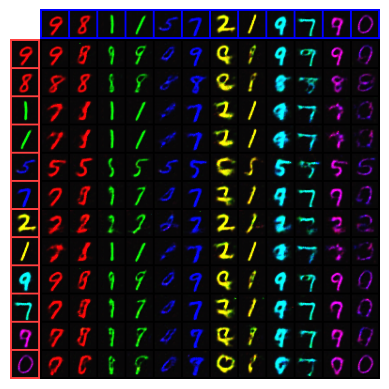

mlvae


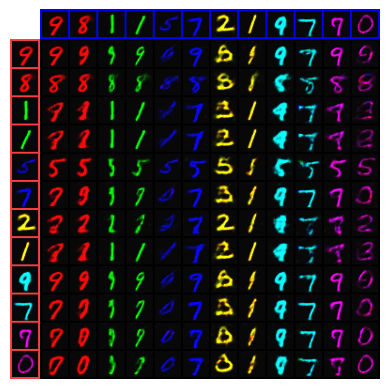

clear


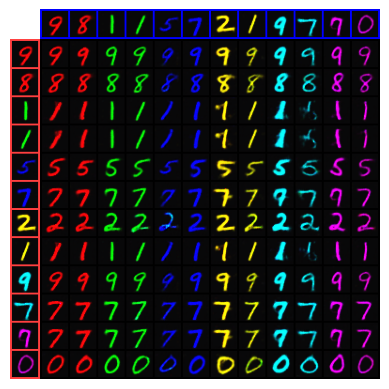

clear-tc


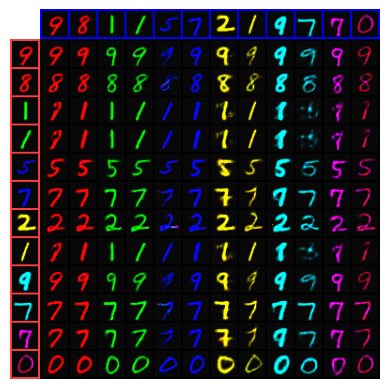

clear-mim (L1OutUB)


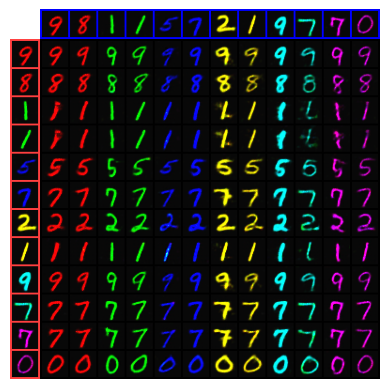

clear-mim (CLUB-S)


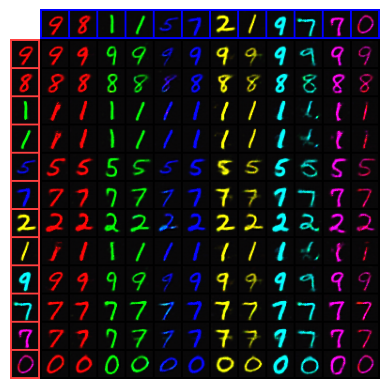

In [20]:
for model_name in trained_model.keys():
    print(model_name)
    model = trained_model[model_name].model
    model.eval()
    X_hat, latent_params, z = model(X.clone(), explicit=True)
    plot_handler(model, X_hat, z, img_idx)

### Interpolation plot usage


```{python}
interpolation_plot(X, z_acc, gvae, int(Z_DIM / 2), inter_steps=8)
```